In [33]:
library(data.table)

library(ggplot2)
library(microbenchmark)

setwd('/path/to/working/directory')
rm(list=ls())

## Import Data

In [34]:
census_dt <- fread(file='Data/CHI_CommAreas_Census2010.csv', sep=",", header=TRUE, skip=1)

head(census_dt, 10)

Geog,GeogKey,Total Population,"Not Hispanic or Latino, White alone","Not Hispanic or Latino, Black or African American alone","Not Hispanic or Latino, American Indian and Alaska Native alone","Not Hispanic or Latino, Asian alone","Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone","Not Hispanic or Latino, Some Other Race alone","Not Hispanic or Latino, Two or More Races",⋯,Median Age,Total Households,Average Household Size,Total Housing Units,Occupied Housing Units,Vacant Housing Units,Occupied Housing Units.1,Owned with a mortgage or a loan,Owned free and clear,Renter occupied
Rogers Park,1,54991,21618,14461,142,3523,39,202,1573,⋯,32.4,24292,2.13,27564,24292,3272,24292,6128,1009,17155
West Ridge,2,71942,30706,8015,189,16184,3,225,1919,⋯,35.1,24755,2.85,27466,24755,2711,24755,8829,3367,12559
Uptown,3,56362,29098,11275,191,6414,10,130,1235,⋯,35.5,29719,1.79,32541,29719,2822,29719,8298,1230,20191
Lincoln Square,4,39493,24916,1488,72,4399,11,128,917,⋯,33.5,18194,2.14,19906,18194,1712,18194,5482,1406,11306
North Center,5,31867,24634,738,55,1449,16,51,594,⋯,32.5,14561,2.18,16197,14561,1636,14561,5805,1147,7609
Lake View,6,94368,75845,3651,110,5653,44,140,1727,⋯,30.4,54425,1.72,59529,54425,5104,54425,16640,3488,34297
Lincoln Park,7,64116,53138,2753,54,3296,17,116,1171,⋯,28.9,33536,1.80,36864,33536,3328,33536,11409,2963,19164
Near North Side,8,80484,58033,8732,79,8140,25,163,1338,⋯,35.2,51714,1.52,62364,51714,10650,51714,17237,5991,28486
Edison Park,9,11187,9885,29,3,269,1,8,120,⋯,41.4,4726,2.37,4964,4726,238,4726,2478,1186,1062
Norwood Park,10,37023,30157,164,54,1696,1,38,471,⋯,43.0,14937,2.44,15848,14937,911,14937,7758,4009,3170


## Extract Data

In [35]:
extract_fct <- function() {
  
  race_dt <<- census_dt[, .SD, .SDcols = names(census_dt) %like% "Geog|Hispanic"]
  
  age_dt <<- census_dt[, .SD, .SDcols = names(census_dt) %like% "Geog|years"]
  
  gender_dt <<- census_dt[, .SD, .SDcols = names(census_dt) %like% "Geog|Population|Male|Female"]
  
  educ_dt <<- fread(file='Data/CHI_CommAreas_Educ2010.csv', sep=",", header=TRUE)
    
  hholds_dt <<- census_dt[, .SD, .SDcols = names(census_dt) %like% "Geog|Households"]
  
  housing_dt <<- census_dt[, .SD, .SDcols = names(census_dt) %like% "Geog|Total.Housing|Occupied|Vacant"]
  housing_dt <<- housing_dt[,unique(names(housing_dt)),with=FALSE]
  
  occupied_dt <<- census_dt[, .SD, .SDcols = names(census_dt) %like% "Geog|Owned|Renter"]
}

In [36]:
extract_fct()

## Reshape Data

In [37]:
reshape_fct <- function() {
  
  # RACE
  race_long_dt <<- melt(race_dt, id.vars = c("Geog", "GeogKey"), 
                       variable.name = "Race_Ethnicity", value.name = "Population")
  
  # AGE
  age_dt[, gsub("Male", "Age", names(age_dt)[names(age_dt) %like% "Male"])] <<- 
    age_dt[, .SD, .SDcols = names(age_dt) %like% "Male"] +
    age_dt[, .SD, .SDcols = names(age_dt) %like% "Female"]
  
  age_dt <<- age_dt[, .SD, .SDcols = names(age_dt) %like% "Geog|Age"]
  
  age_long_dt <<- melt(age_dt, id.vars = c("Geog", "GeogKey"), 
                       variable.name = "Age_Group", value.name = "Population")
  
  # GENDER
  gender_dt <<- gender_dt[ ,male := rowSums(.SD), .SDcols = names(gender_dt) %like% "^Male"]
  gender_dt <<- gender_dt[ ,female := rowSums(.SD), .SDcols = names(gender_dt) %like% "Female"]
  
  all.equal(gender_dt$`Total Population`, gender_dt$male + gender_dt$female)
  
  gender_long_dt <<- melt(gender_dt[, .SD, .SDcols=names(gender_dt) %like% "Geog|^male|female"], 
                          id.vars = c("Geog", "GeogKey"), 
                          variable.name = "Gender", value.name = "Population")
  
  # EDUCATION
  educ_long_dt <<- melt(educ_dt[,.SD,.SDcols=names(educ_dt) %like% "Geog|^Total"], 
                        id.vars = c("Geog", "GeogKey"), 
                        variable.name = "Education_Level", value.name = "Population")
  
  ## HOUSEHOLD
  hholds_long_dt <<- hholds_dt
  
  ## HOUSING UNITS
  housing_long_dt <<- melt(housing_dt, id.vars = c("Geog", "GeogKey"),
                           variable.name = "Occupied_Status", value.name = "Housing_Units")
  
  ## OCCUPIED HOUSING
  occupied_long_dt <<- melt(occupied_dt, id.vars = c("Geog", "GeogKey"),
                            variable.name = "Occupied_Type", value.name = "Housing_Units")
}

In [38]:
reshape_fct()

## Summarize Data

In [39]:
summarize_fct <- function() {
  
  # COMM AREA
  comm_aggdt <- census_dt[, list(mean_population = mean(`Total Population`),
                                        median_population = median(`Total Population`),
                                        min_population = min(`Total Population`),
                                        max_population = max(`Total Population`),
                                        total_population = sum(`Total Population`)), ]
  
  # RACE
  setkey(race_long_dt, Race_Ethnicity)
  race_aggdt <- race_long_dt[, list(mean_popluation = mean(Population),
                                    median_population = median(Population),
                                    min_population = min(Population),
                                    max_population = max(Population),
                                    total_popluation = sum(Population)), by = Race_Ethnicity]
  
  # AGE
  setkey(age_long_dt, Age_Group)
  age_aggdt <- age_long_dt[, list(mean_popluation = mean(Population),
                                  median_population = median(Population),
                                  min_population = min(Population),
                                  max_population = max(Population),
                                  total_popluation = sum(Population)), by = Age_Group]
  
  # GENDER
  setkey(gender_long_dt, Gender)
  gender_aggdt <- gender_long_dt[, list(mean_popluation = mean(Population),
                                        median_population = median(Population),
                                        min_population = min(Population),
                                        max_population = max(Population),
                                        total_popluation = sum(Population)), by = Gender]
  
  # EDUCATION
  setkey(educ_long_dt, Education_Level)
  educ_aggdt <- educ_long_dt[, list(mean_popluation = mean(Population),
                                    median_population = median(Population),
                                    min_population = min(Population),
                                    max_population = max(Population),
                                    total_popluation = sum(Population)), by = Education_Level]
  
  # HOUSEHOLDS
  hholds_aggdt <- hholds_long_dt[, list(mean_households = mean(`Total Households`),
                                        median_households = median(`Total Households`),
                                        min_households = min(`Total Households`),
                                        max_households = max(`Total Households`),
                                        total_households = sum(`Total Households`)), ]
  
  # HOUSING
  setkey(housing_long_dt, Occupied_Status)
  housing_aggdt <- housing_long_dt[, list(mean_housing_units = mean(Housing_Units),
                                          median_housing_units = median(Housing_Units),
                                          min_housing_units = min(Housing_Units),
                                          max_housing_units = max(Housing_Units),
                                          total_housing_units = sum(Housing_Units)), by = Occupied_Status]

  # OCCUPIED
  setkey(occupied_long_dt, Occupied_Type)
  
  occupied_aggdt <- occupied_long_dt[, list(mean_housing_units = mean(Housing_Units),
                                            median_housing_units = median(Housing_Units),
                                            min_housing_units = min(Housing_Units),
                                            max_housing_units = max(Housing_Units),
                                            total_housing_units = sum(Housing_Units)), by = Occupied_Type]

  list(comm_aggdt, race_aggdt, age_aggdt, gender_aggdt, educ_aggdt, hholds_aggdt, housing_aggdt, occupied_aggdt)
}


In [40]:
summarize_fct()

[[1]]
   mean_population median_population min_population max_population
1:        35007.77             31028           2876          98514
   total_population
1:          2695598

[[2]]
                                                             Race_Ethnicity
1:                                      Not Hispanic or Latino, White alone
2:                  Not Hispanic or Latino, Black or African American alone
3:          Not Hispanic or Latino, American Indian and Alaska Native alone
4:                                      Not Hispanic or Latino, Asian alone
5: Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone
6:                            Not Hispanic or Latino, Some Other Race alone
7:                                Not Hispanic or Latino, Two or More Races
8:                                                       Hispanic or Latino
   mean_popluation median_population min_population max_population
1:    11100.220779              4364             19          75845
2:    11328.389610              6122             29          83837
3:       53.207792                41              0            191
4:     1881.857143               294              0          16184
5:        7.233766                 3              0             44
6:       54.896104                30              0            225
7:      466.870130               321             26           1919
8:    10115.090909              4442             20          65457
   total_popluation
1:           854717
2:           872286
3:             4097
4:           144903
5:              557
6:             4227
7:            35949
8:           778862

[[3]]
                 Age_Group mean_popluation median_population min_population
 1: Age: Under 5 years old       2414.1169              2080            161
 2:      Age: 5 to 9 years       2156.8442              1772            177
 3:    Age: 10 to 14 years       2135.9221              1688            192
 4:    Age: 15 to 17 years       1366.2338              1182            147
 5:   Age: 18 and 19 years       1009.5195               820             85
 6:          Age: 20 years        533.3896               451             27
 7:          Age: 21 years        521.2727               439             34
 8:    Age: 22 to 24 years       1841.7922              1327             89
 9:    Age: 25 to 29 years       3586.2208              2163            156
10:    Age: 30 to 34 years       3109.2468              1991            161
11:    Age: 35 to 39 years       2604.0000              1939            161
12:    Age: 40 to 44 years       2306.8961              1887            148
13:    Age: 45 to 49 years       2231.9740              1928            172
14:    Age: 50 to 54 years       2167.2078              1910            202
15:    Age: 55 to 59 years       1878.0649              1672            163
16:   Age: 60 and 61 years        669.5325               595             57
17:    Age: 62 to 64 years        866.0260               696             80
18:   Age: 65 and 66 years        472.8961               393             44
19:    Age: 67 to 69 years        631.9091               552             72
20:    Age: 70 to 74 years        857.4675               756             91
21:    Age: 75 to 79 years        658.4416               592             80
22:    Age: 80 to 84 years        507.8442               456             49
23: Age: 85 years and over        480.9481               400             41
                 Age_Group mean_popluation median_population min_population
    max_population total_popluation
 1:           7331           185887
 2:           6822           166077
 3:           7547           164466
 4:           5274           105200
 5:           3358            77733
 6:           1659            41071
 7:           1584            40138
 8:          10765           141818
 9:          23641           276139
10:          13779           239412
11:           8360           200508
12:    

## Graphing Data

In [41]:
graphing_fct <- function() {
  
  # COMM AREA
  setorder(census_dt, -`Total Population`)
  
  comm_plot <- ggplot(head(census_dt, 10), aes(x=Geog, y=`Total Population`, fill=factor(Geog))) + 
    geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
    guides(fill=guide_legend(title="Geog", ncol=15)) +
    labs(title="Top Ten Chicago Community Area - Total Population", 
         y="Total Population", x="Chicago Community Areas") +
    theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
    scale_fill_hue(l=45)

  # RACE
  setkey(race_long_dt, Race_Ethnicity)
  setorder(race_long_dt, Race_Ethnicity, -Population)
  
  grp_dt <- race_long_dt[, .SD[Population %in% head(Population, 10)], by = Race_Ethnicity]

  race_plots <- lapply(split(grp_dt, by=c("Race_Ethnicity")), function(dt){
    grp <- dt$Race_Ethnicity[1]
    
    ggplot(dt, aes(x=Geog, y=Population, fill=factor(Geog))) + 
      geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
      guides(fill=guide_legend(title="Geog", ncol=15)) +
      labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", grp, sep=" - ")), 
           y="Population", x="Chicago Community Areas") +
      theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
      scale_fill_hue(l=45)
  })
  
  # AGE
  setkey(age_long_dt, Age_Group)
  setorder(age_long_dt, Age_Group, -Population)
  
  grp_dt <- age_long_dt[, .SD[Population %in% head(Population, 10)], by = Age_Group]

  age_plots <- lapply(split(grp_dt, by="Age_Group"), function(dt){
    grp <- dt$Age_Group[1]
    
    ggplot(dt, aes(x=Geog, y=Population, fill=factor(Geog))) + 
      geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
      guides(fill=guide_legend(title="Geog", ncol=15)) +
      labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", grp, sep=" - ")), 
           y="Population", x="Chicago Community Areas") +
      theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
      scale_fill_hue(l=45)
  })
  
  # GENDER
  setkey(gender_long_dt, Gender)
  setorder(gender_long_dt, Gender, -Population)
  
  grp_dt <- gender_long_dt[, .SD[Population %in% head(Population, 10)], by = Gender]

  gender_plots <- lapply(split(grp_dt, by="Gender"), function(dt){
    grp <- dt$Gender[1]
    
    ggplot(dt, aes(x=Geog, y=Population, fill=factor(Geog))) + 
      geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
      guides(fill=guide_legend(title="Geog", ncol=15)) +
      labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", grp, sep=" - ")), 
           y="Population", x="Chicago Community Areas") +
      theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
      scale_fill_hue(l=45)
  })
  
  # EDUCATION
  setkey(educ_long_dt, Education_Level)
  setorder(educ_long_dt, Education_Level, -Population)
  
  grp_dt <- educ_long_dt[, .SD[Population %in% head(Population, 10)], by = Education_Level]

  educ_plots <- lapply(split(grp_dt, by="Education_Level"), function(dt){
    grp <- dt$Education_Level[1]
    
    ggplot(dt, aes(x=Geog, y=Population, fill=factor(Geog))) + 
      geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
      guides(fill=guide_legend(title="Geog", ncol=15)) +
      labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", grp, sep=" - ")), 
           y="Population", x="Chicago Community Areas") +
      theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
      scale_fill_hue(l=45)
  })
  
  # HOUSEHOLDS
  setorder(hholds_long_dt, -`Total Households`)
  
  hhold_plot <- ggplot(head(hholds_long_dt, 10), aes(x=Geog, y=`Total Households`, fill=factor(Geog))) + 
    geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
    guides(fill=guide_legend(title="Geog", ncol=15)) +
    labs(title="Top Ten Chicago Community Area - Total Households", 
         y="Total Households", x="Chicago Community Areas") +
    theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
    scale_fill_hue(l=45)
  
  # HOUSING UNITS
  setkey(housing_long_dt, Occupied_Status)
  setorder(housing_long_dt, Occupied_Status, -Housing_Units)
  
  grp_dt <- housing_long_dt[, .SD[Housing_Units %in% head(Housing_Units, 10)], by = Occupied_Status]

  housing_plots <- lapply(split(grp_dt, by="Occupied_Status"), function(dt){
    grp <- dt$Occupied_Status[1]
    
    ggplot(dt, aes(x=Geog, y=Housing_Units, fill=factor(Geog))) + 
      geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
      guides(fill=guide_legend(title="Geog", ncol=15)) +
      labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", grp, sep=" - ")), 
           y="Housing Units", x="Chicago Community Areas") +
      theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
      scale_fill_hue(l=45)
  })
  
  # OCCUPIED HOUSING
  setkey(occupied_long_dt, Occupied_Type)
  setorder(occupied_long_dt, Occupied_Type, -Housing_Units)
  
  grp_dt <- occupied_long_dt[, .SD[Housing_Units %in% head(Housing_Units, 10)], by = Occupied_Type]
  
  occupied_plots <- lapply(split(grp_dt, by="Occupied_Type"), function(dt){
    grp <- dt$Occupied_Type[1]
    
    ggplot(dt, aes(x=Geog, y=Housing_Units, fill=factor(Geog))) + 
      geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
      guides(fill=guide_legend(title="Geog", ncol=15)) +
      labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", grp, sep=" - ")), 
           y="Housing Units", x="Chicago Community Areas") +
      theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
      scale_fill_hue(l=45)
  })
  
  list(comm_plot, race_plots, age_plots, gender_plots, educ_plots, hhold_plot, housing_plots, occupied_plots)
}


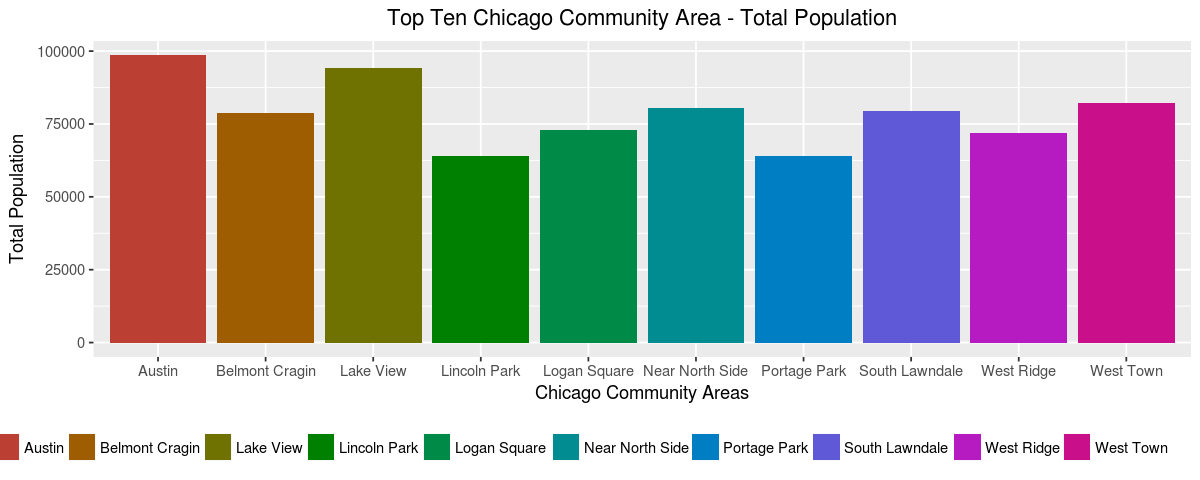

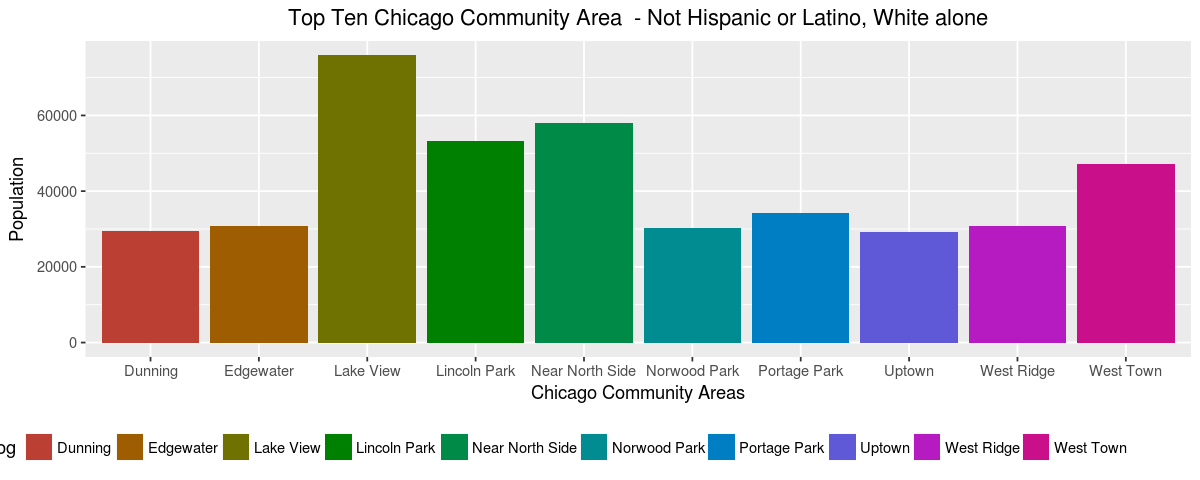

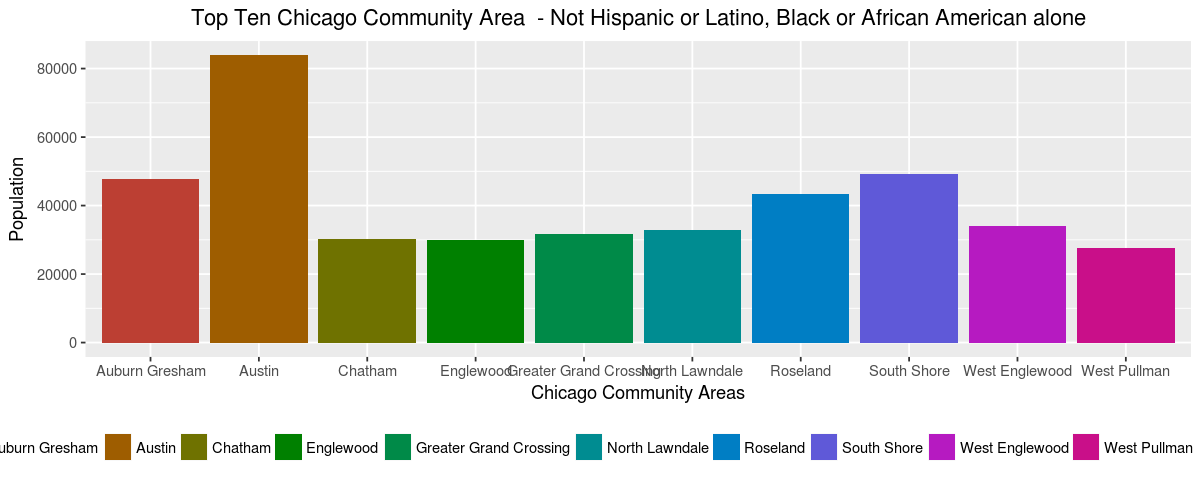

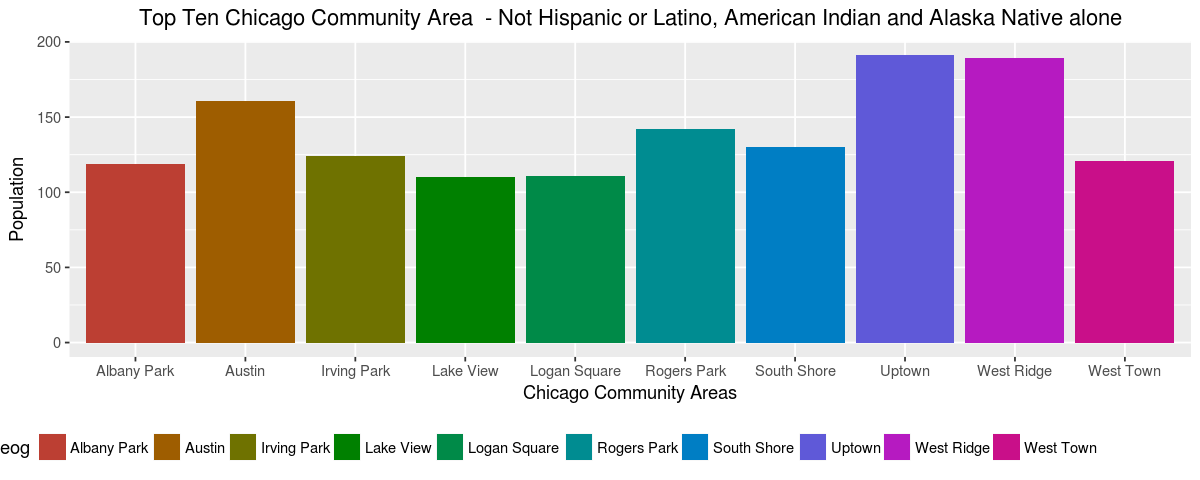

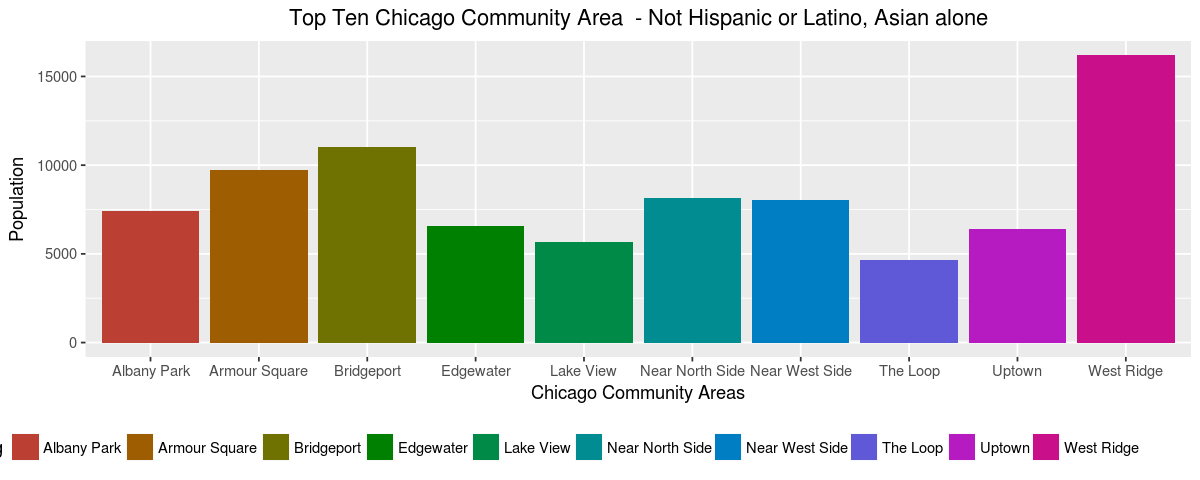

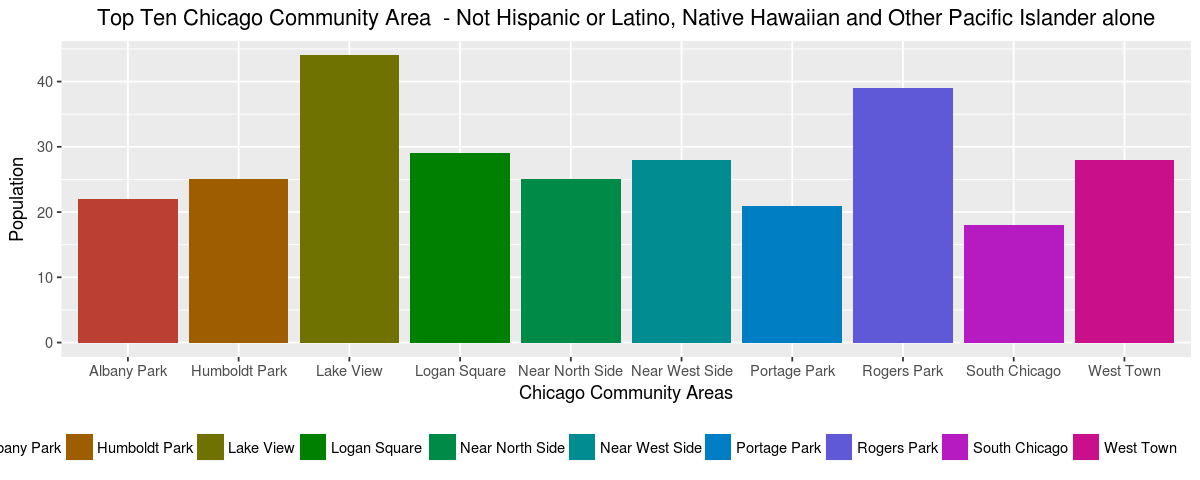

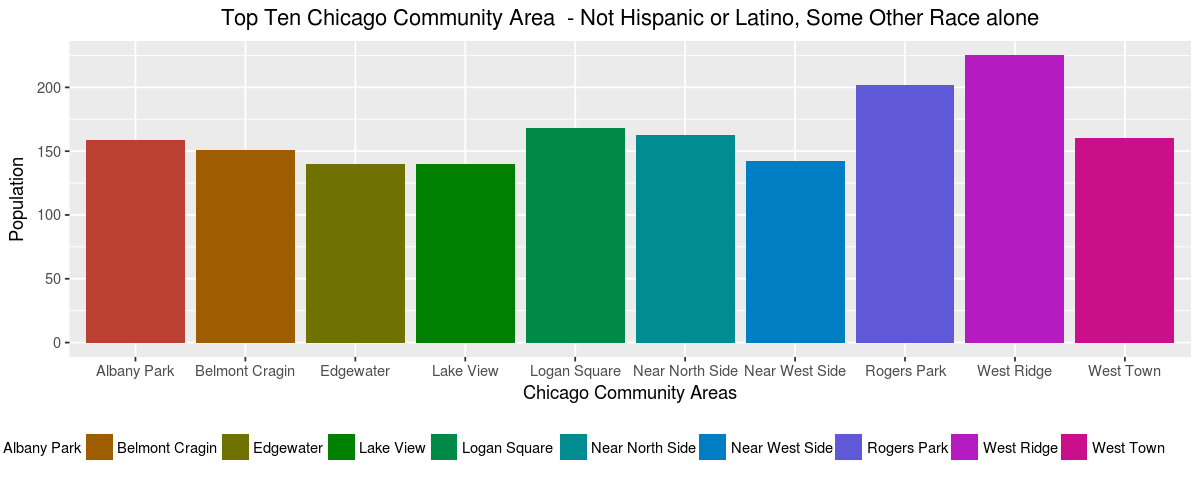

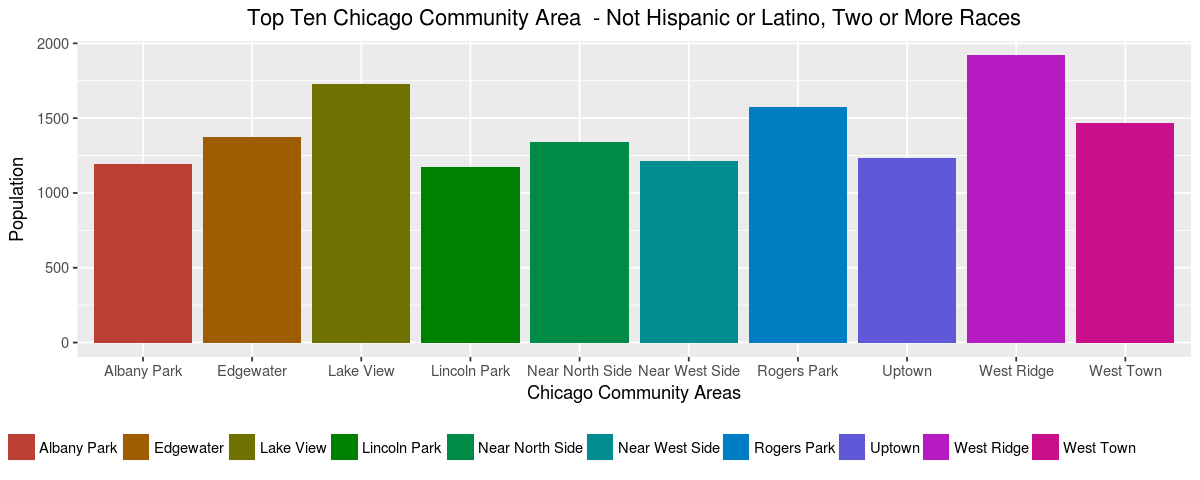

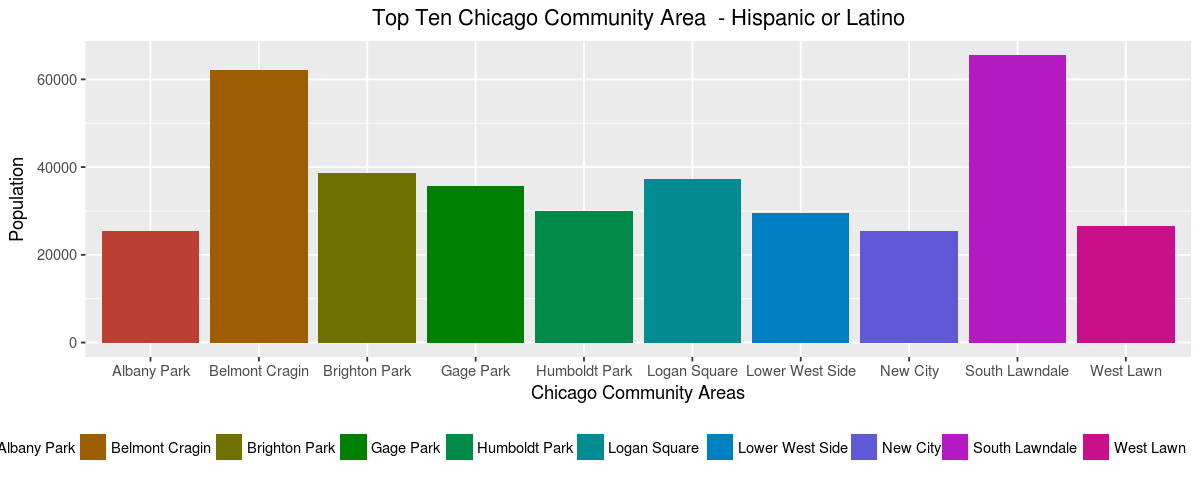

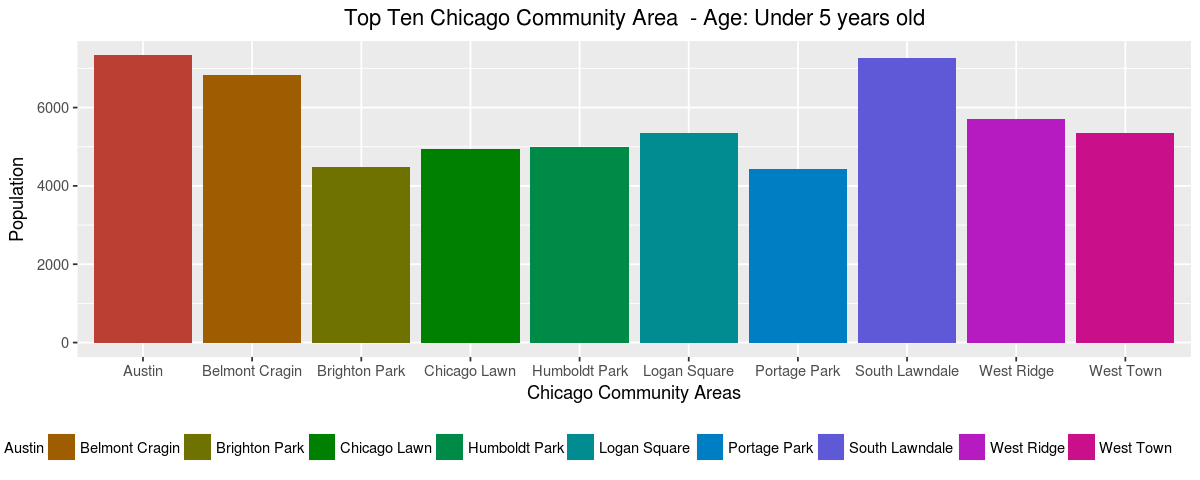

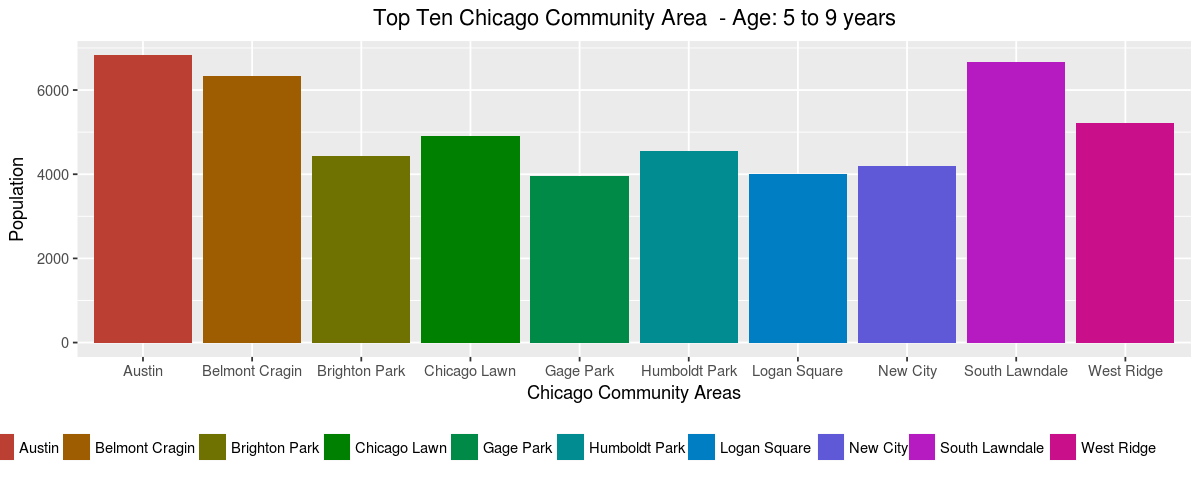

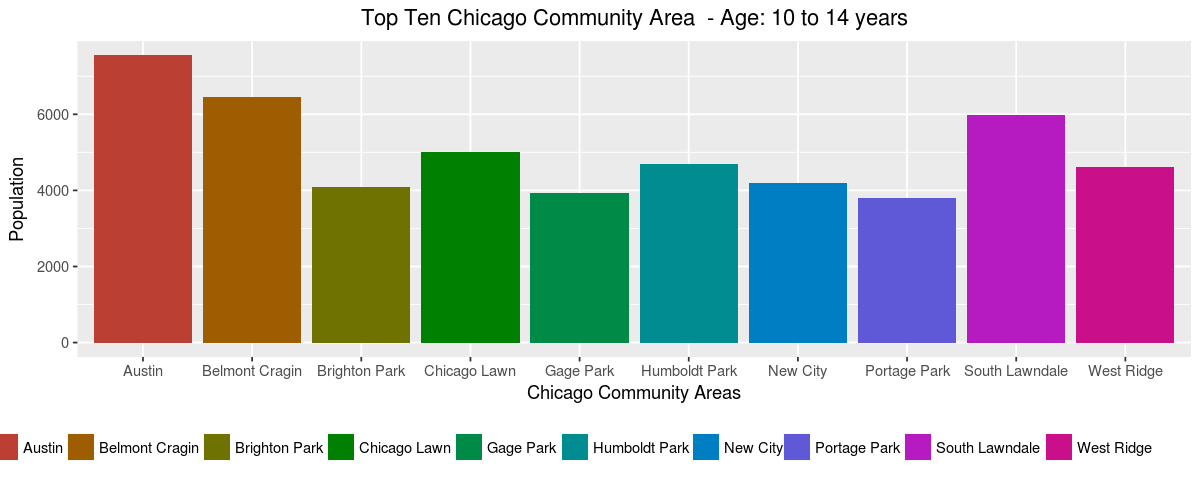

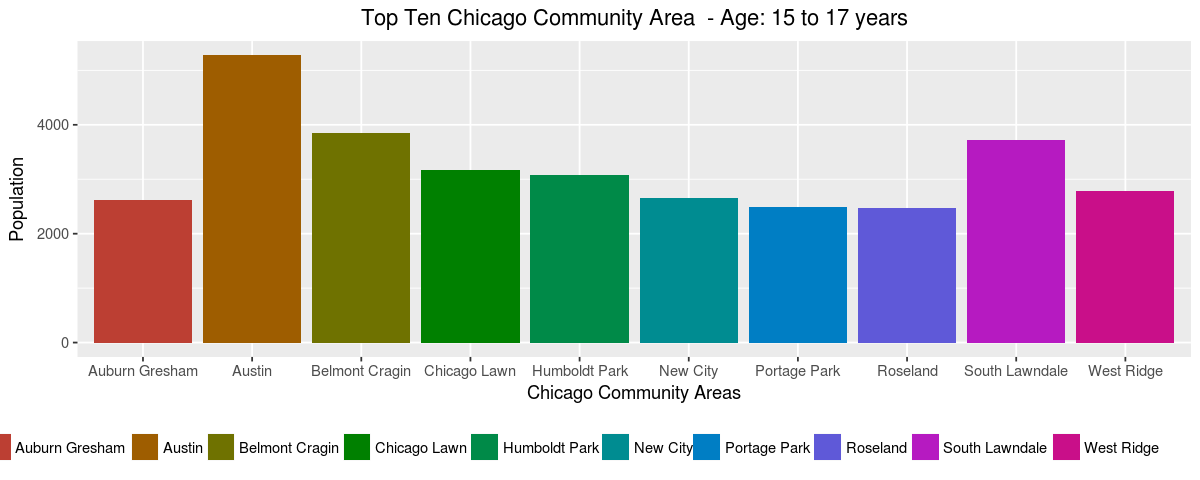

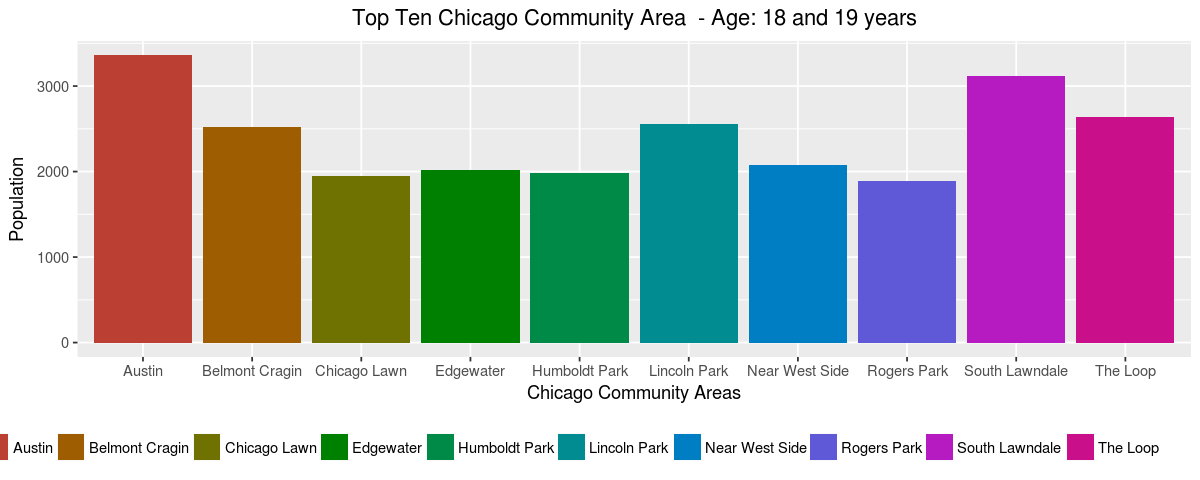

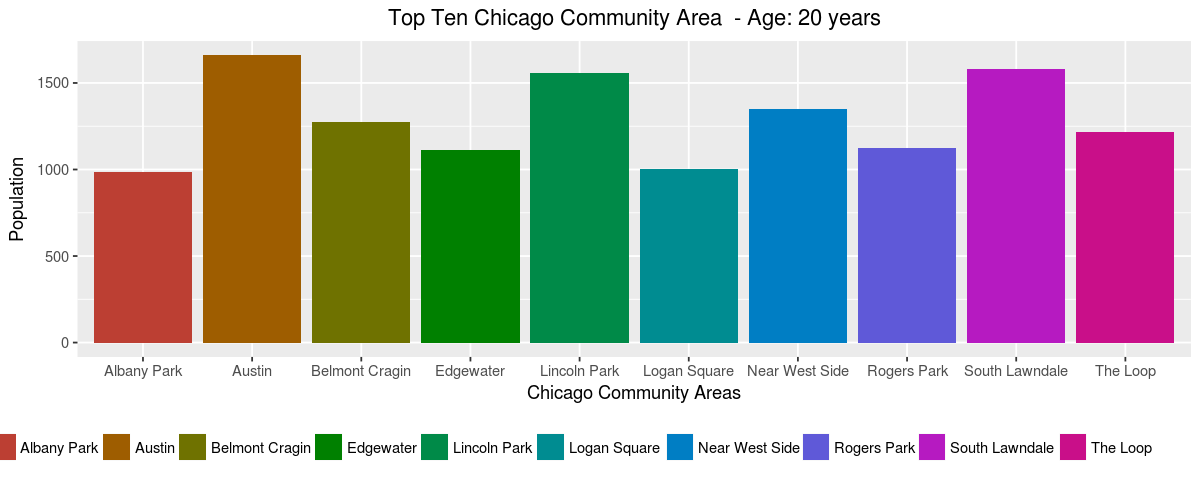

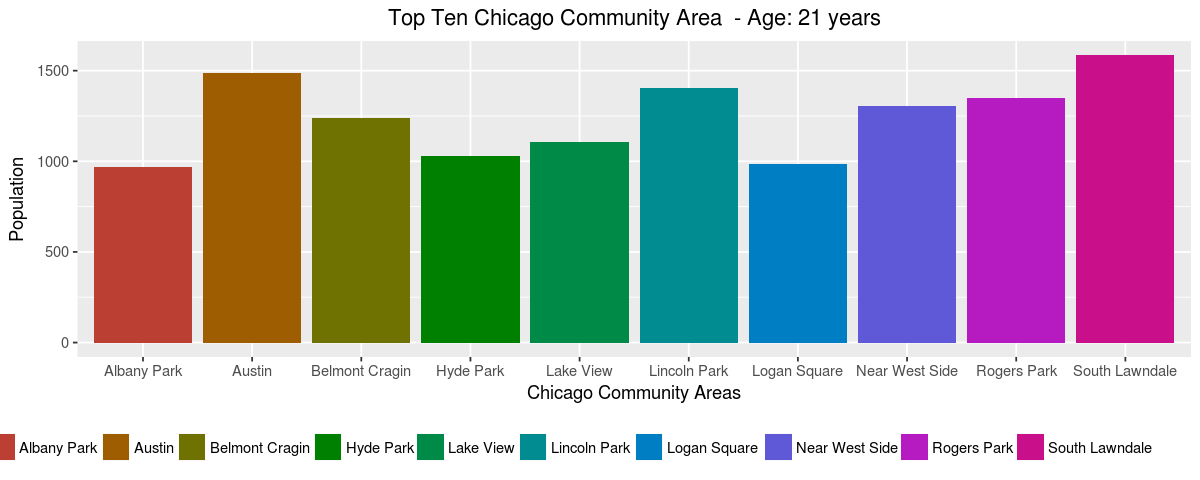

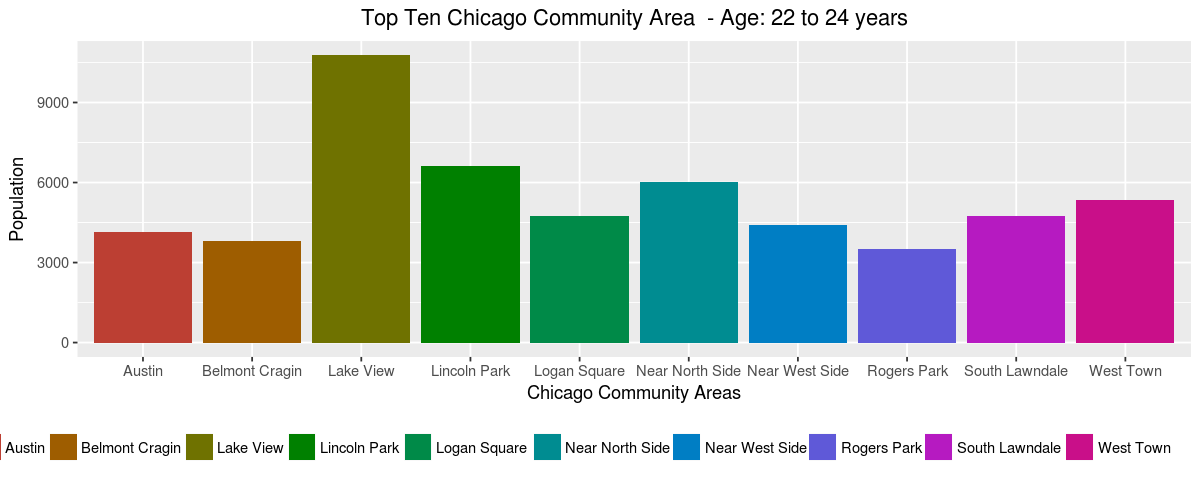

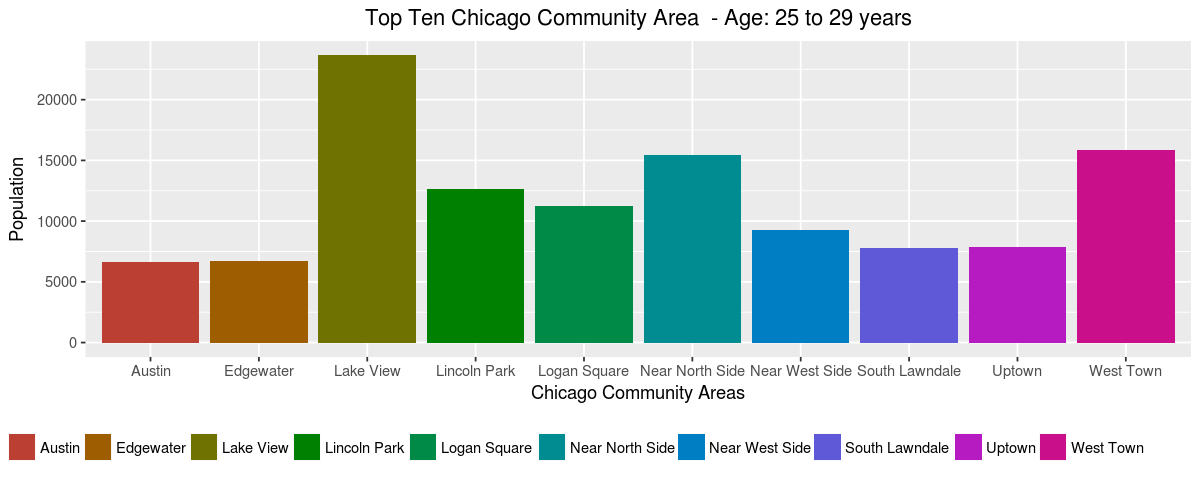

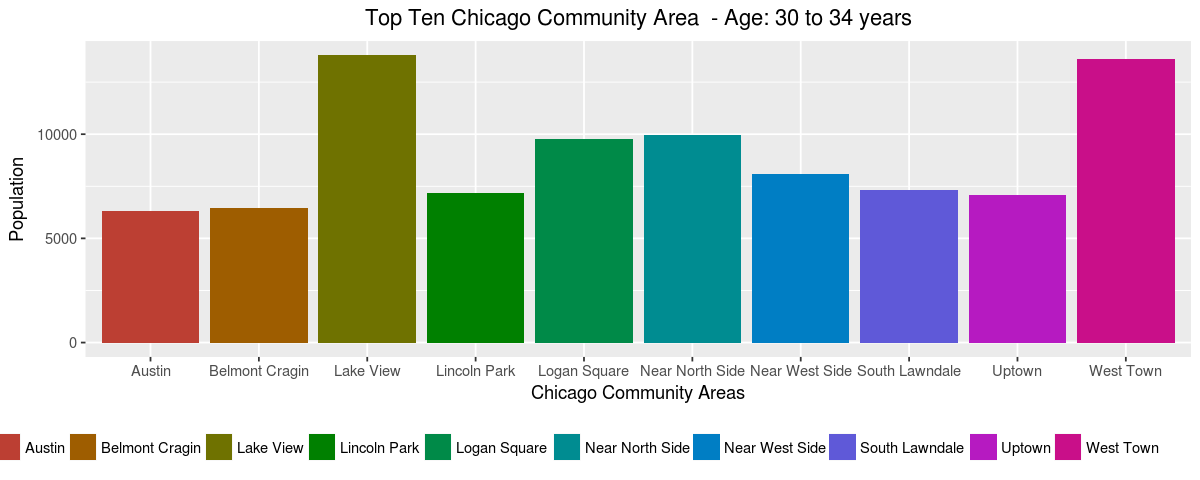

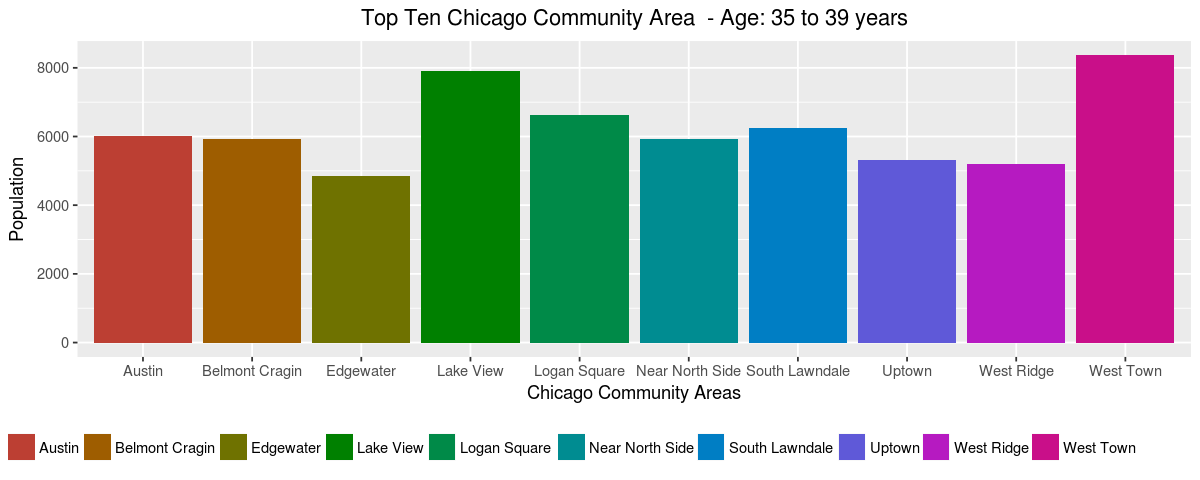

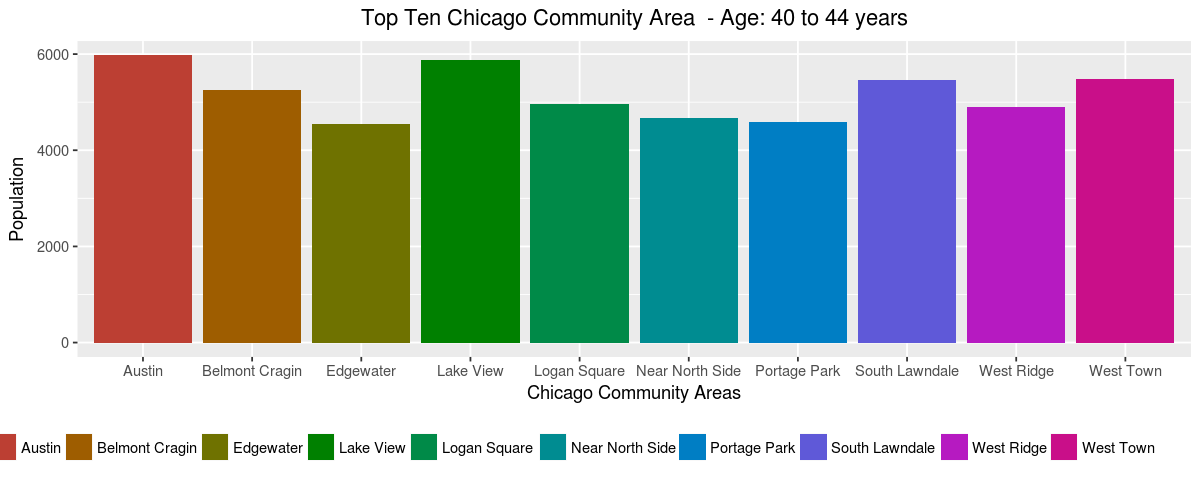

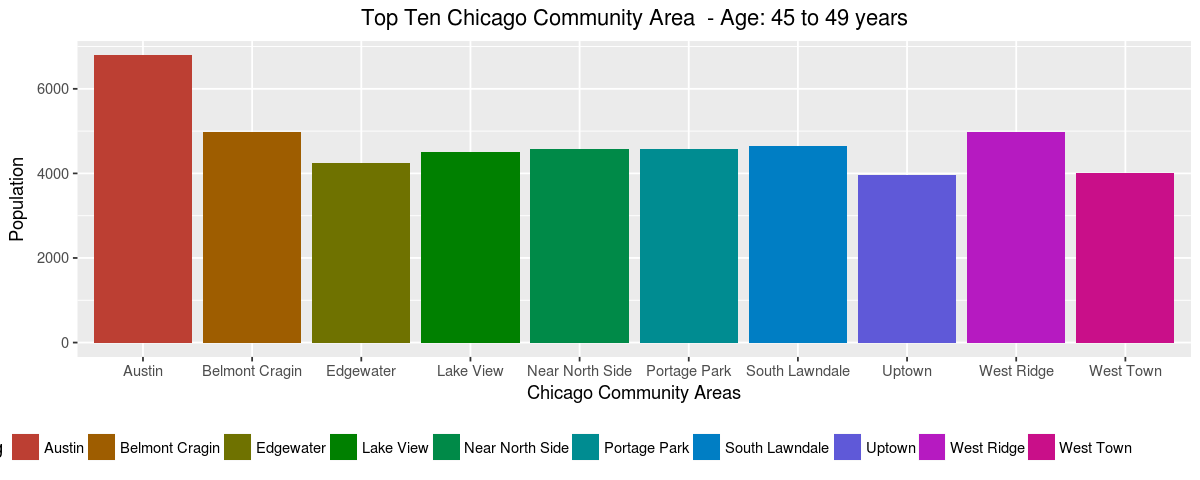

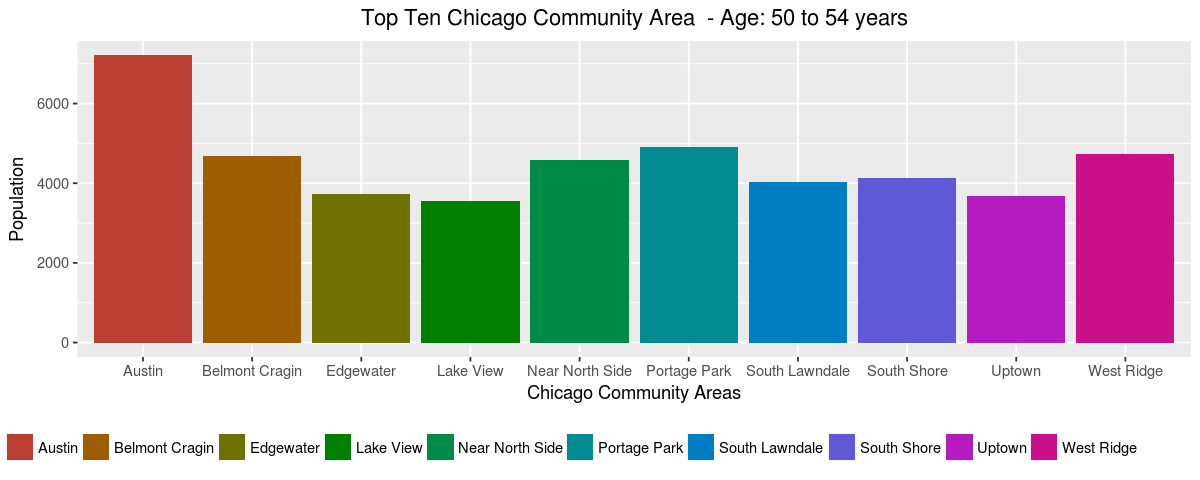

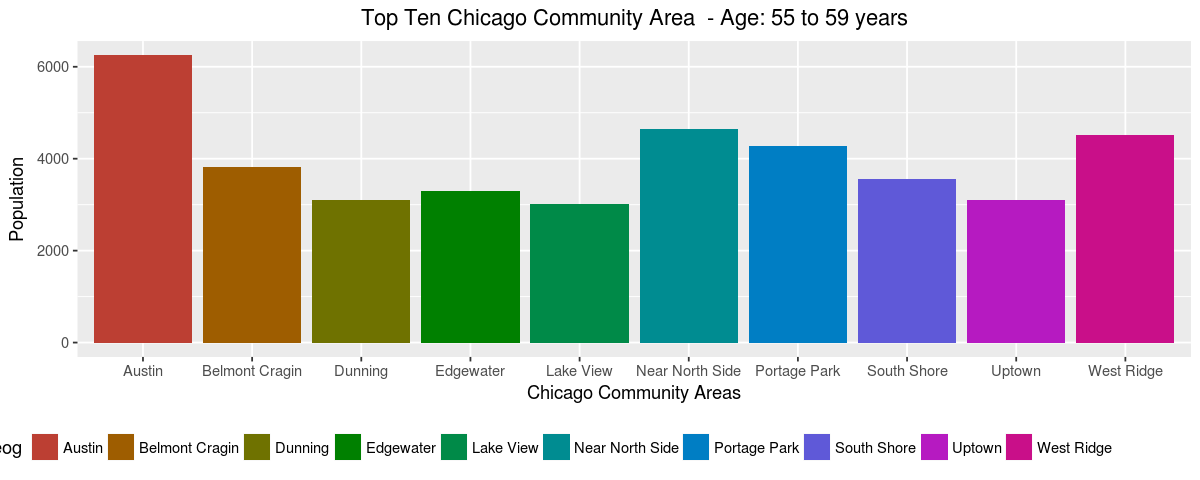

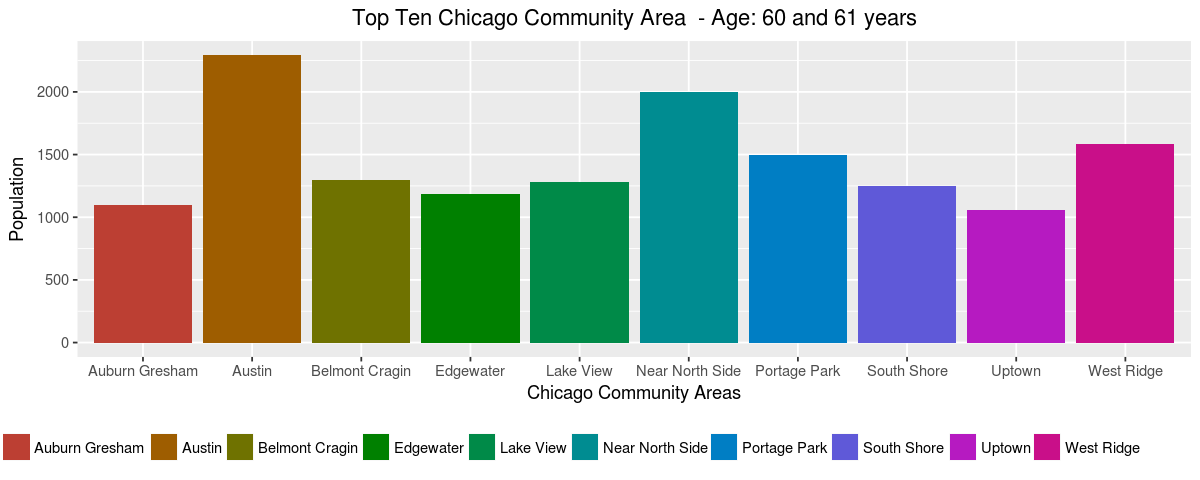

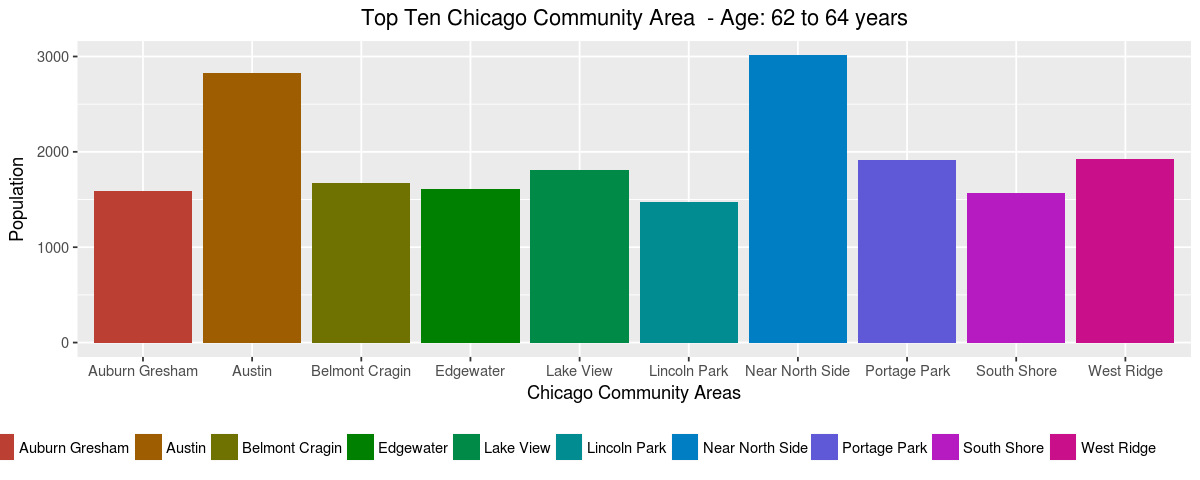

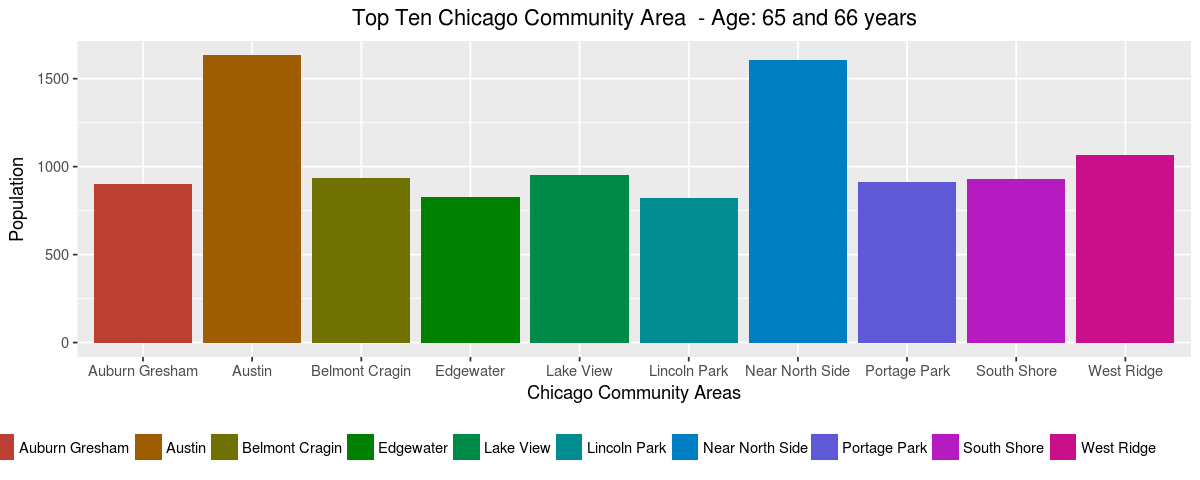

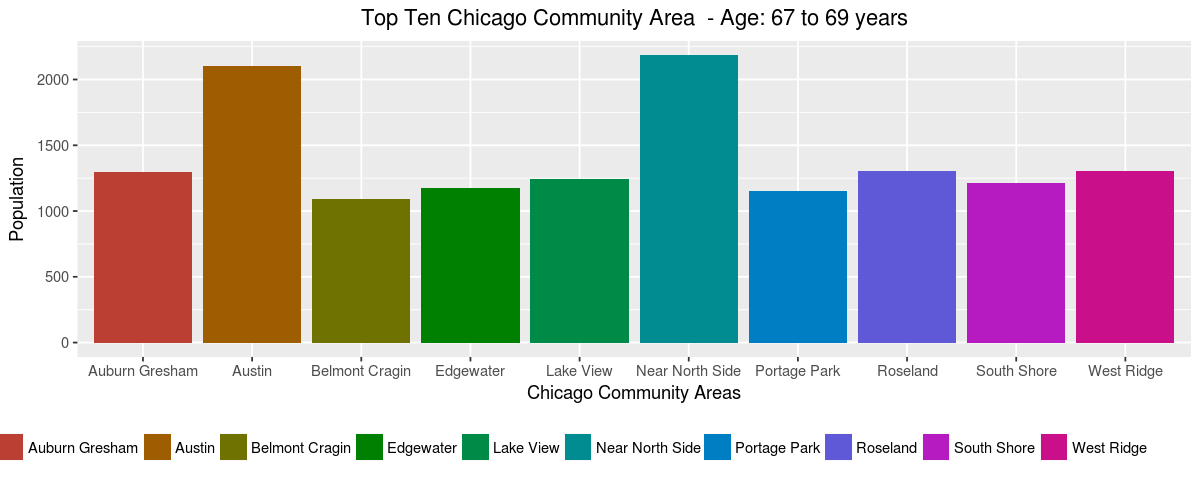

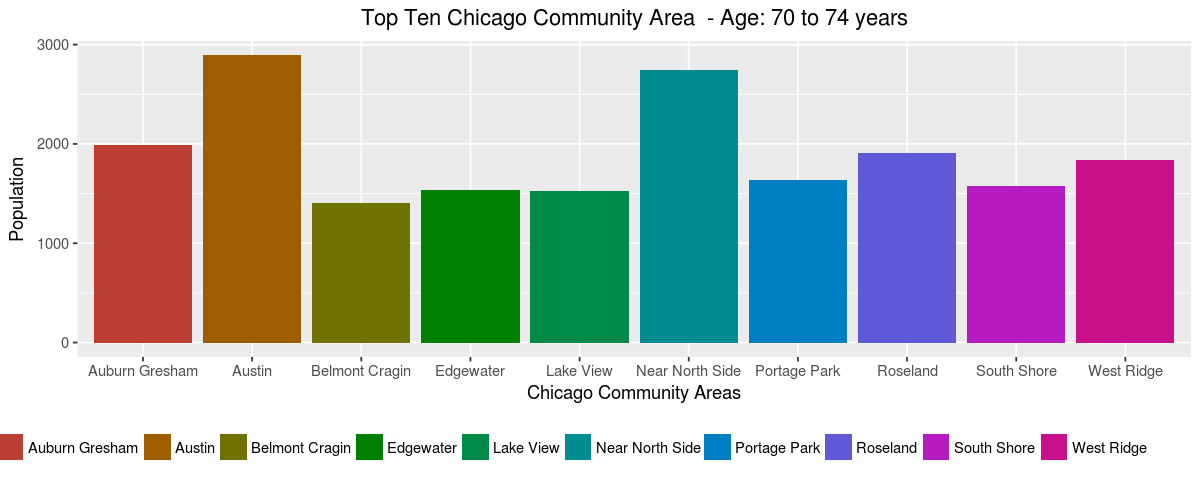

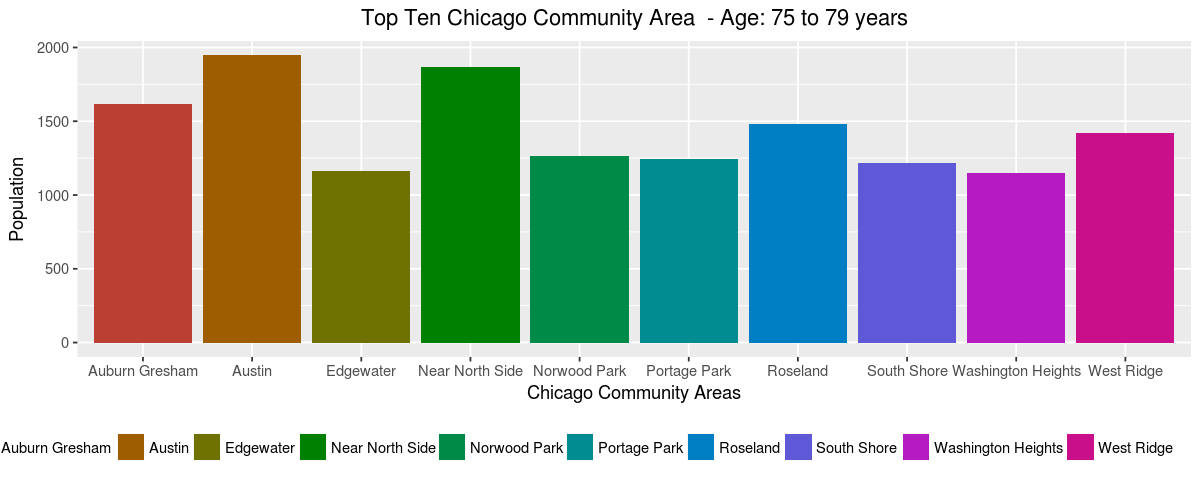

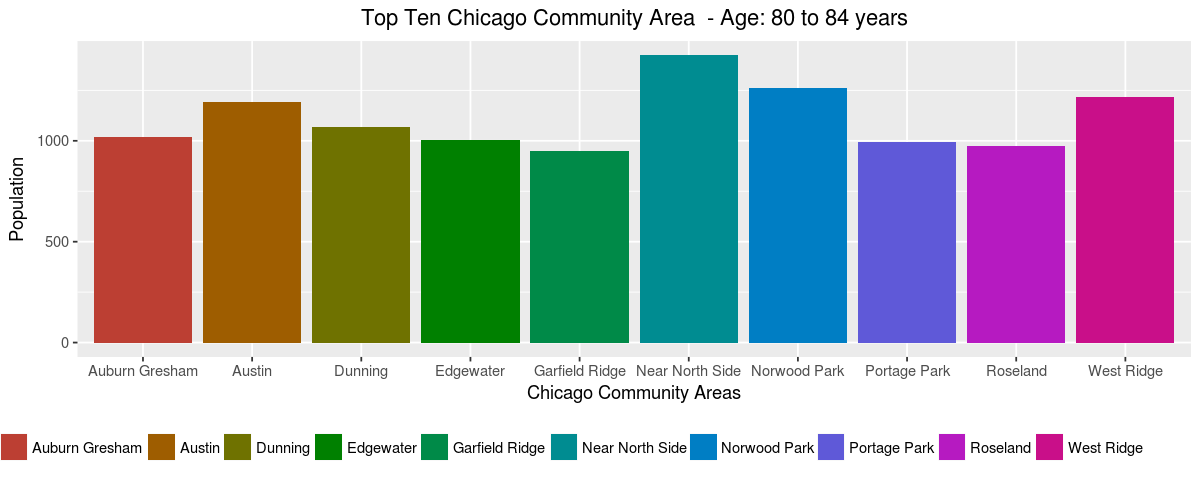

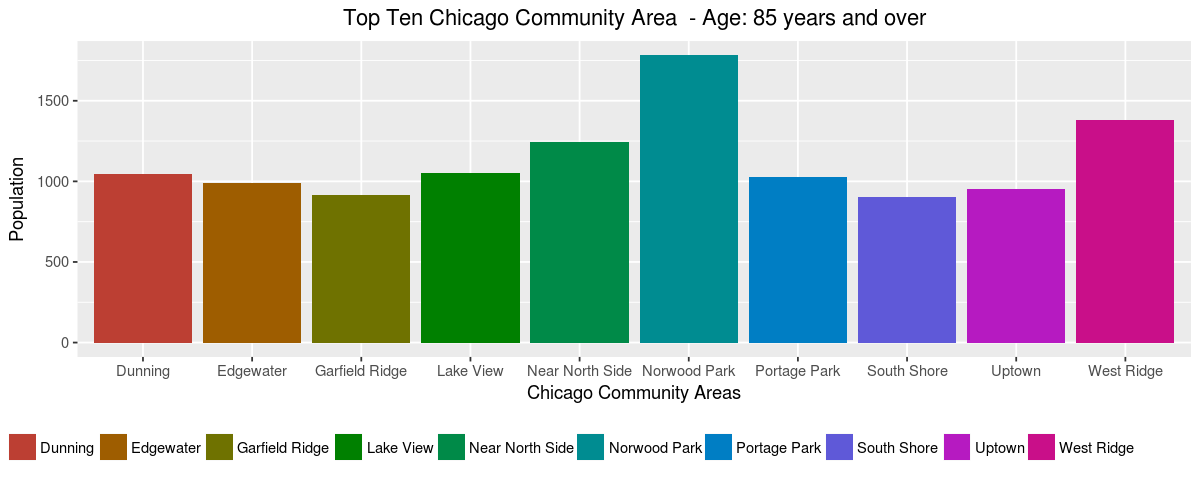

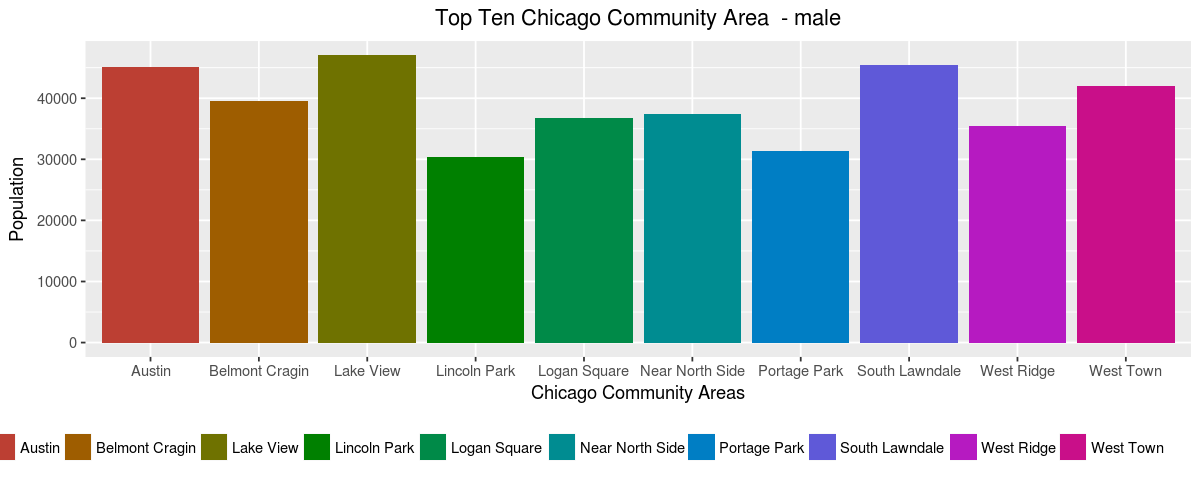

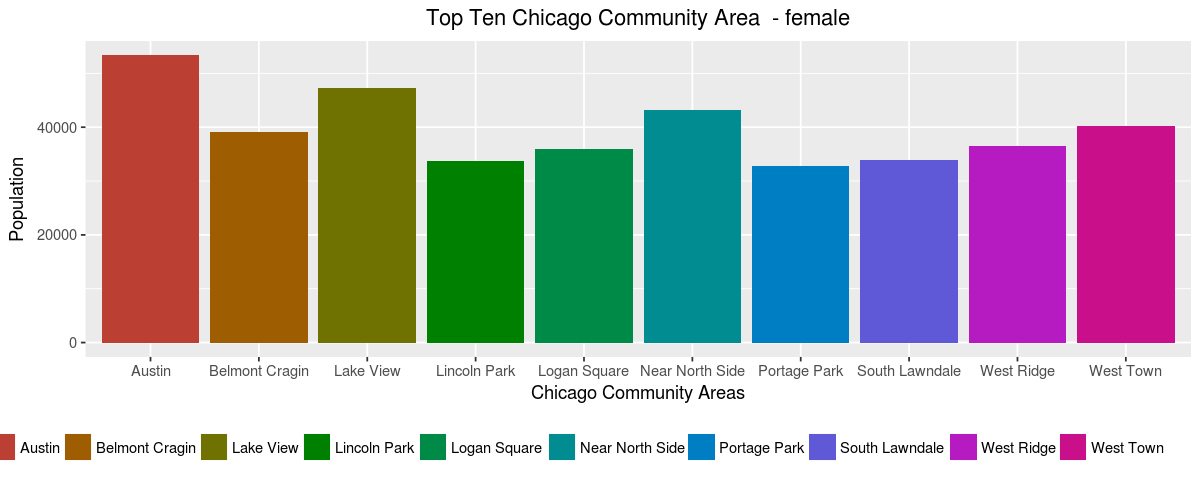

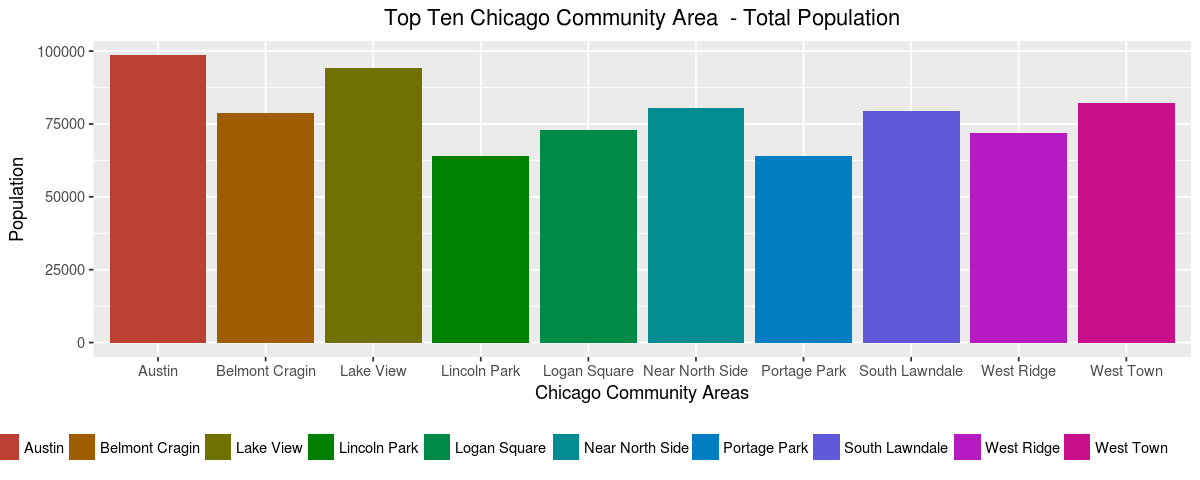

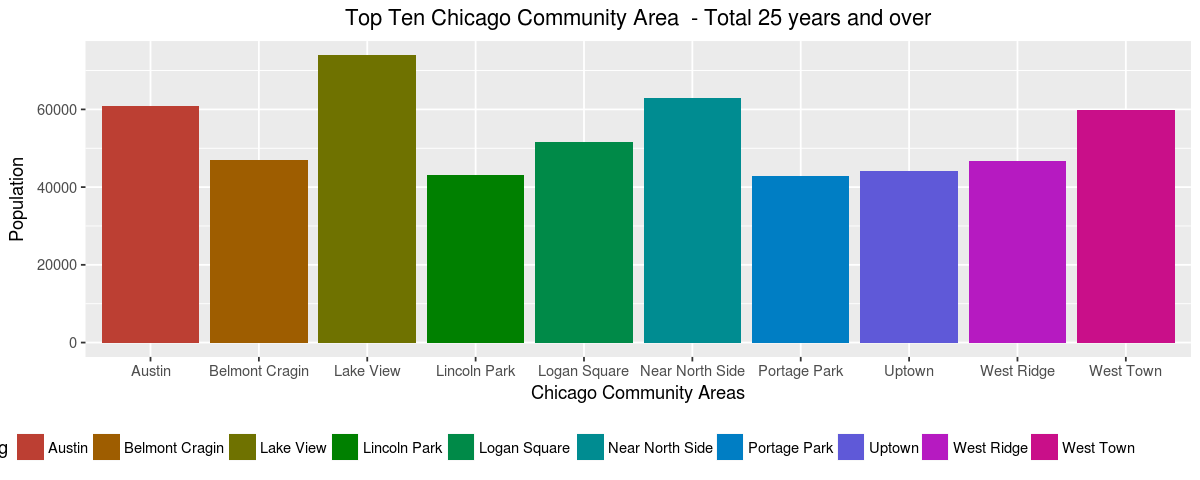

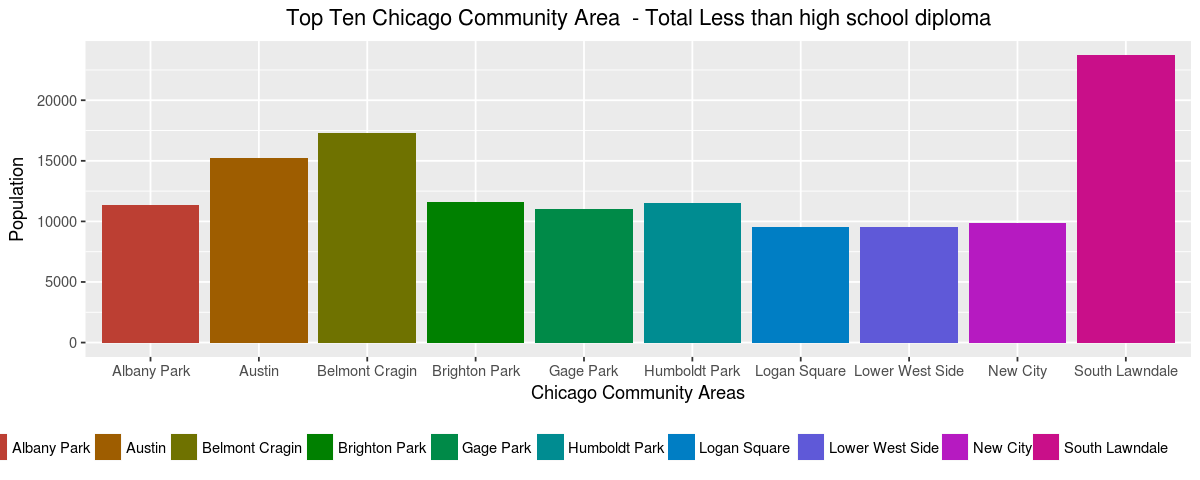

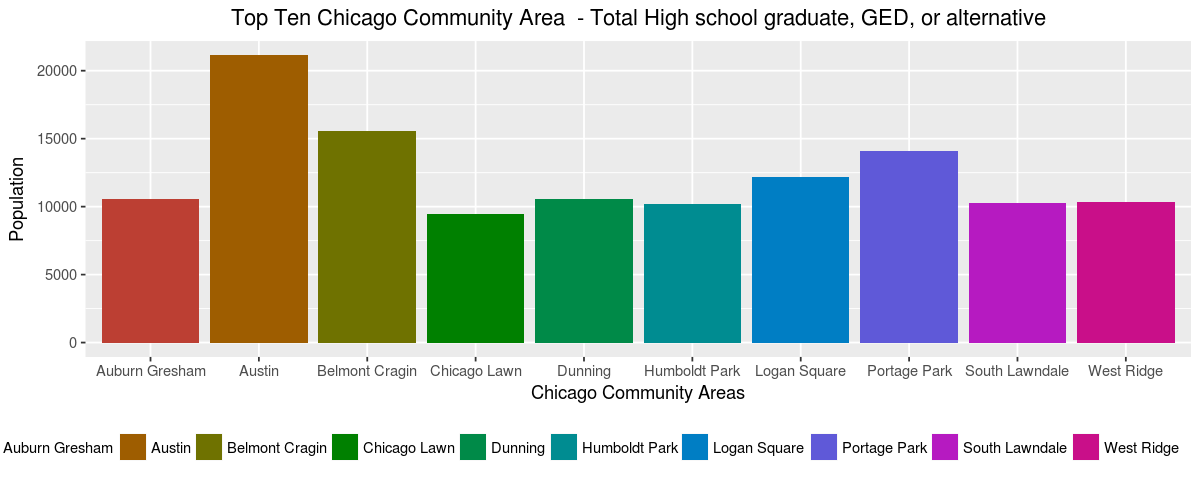

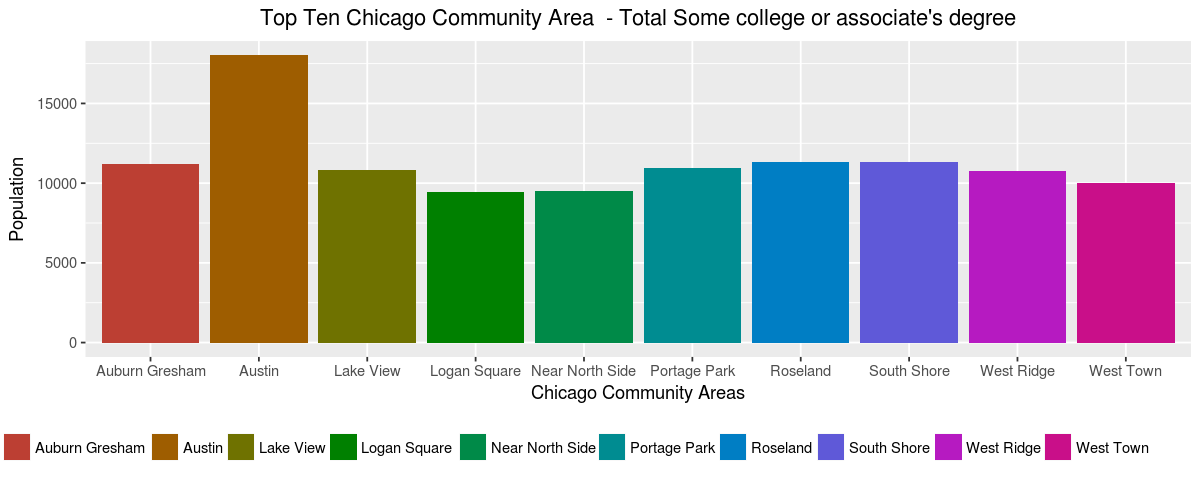

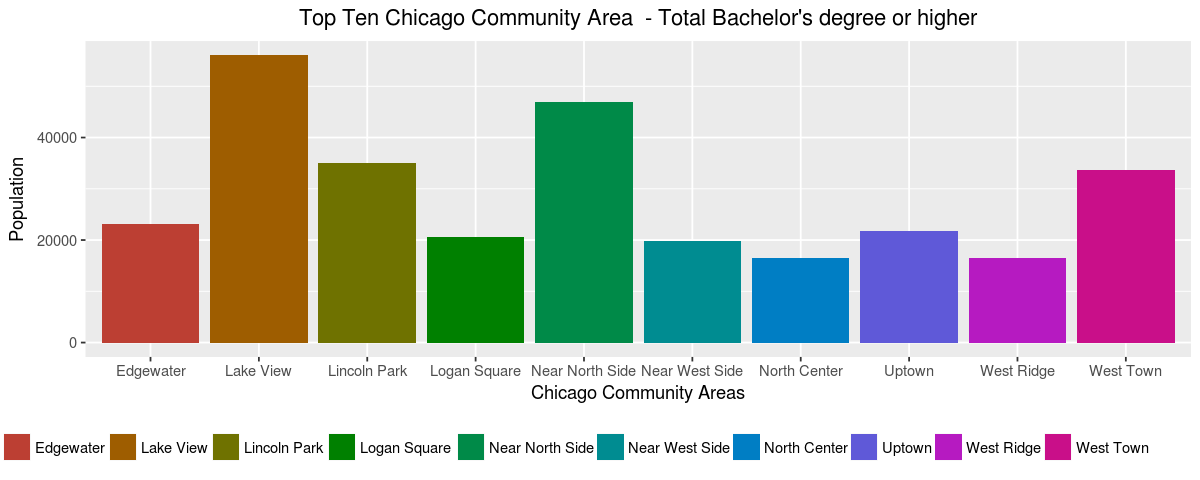

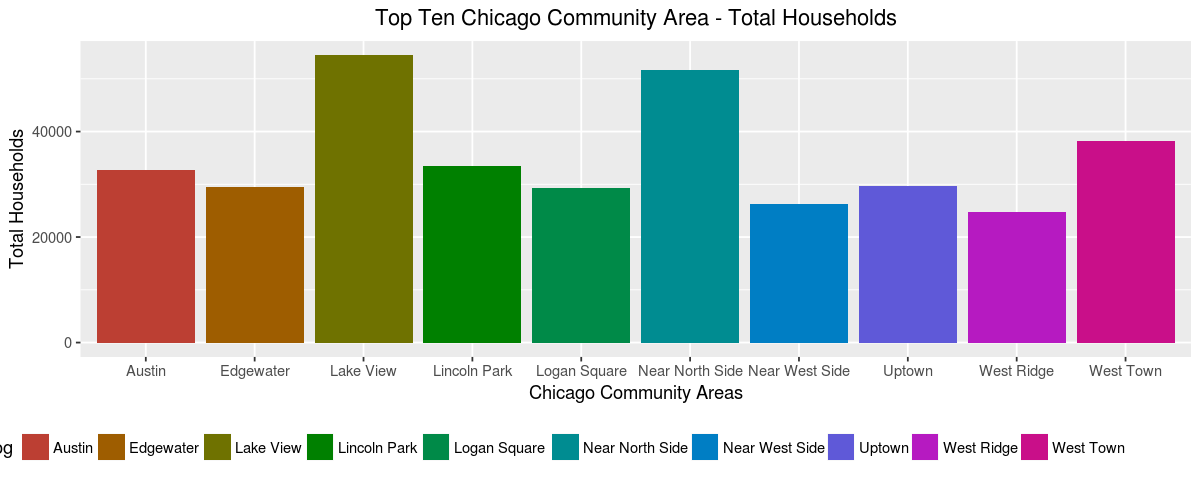

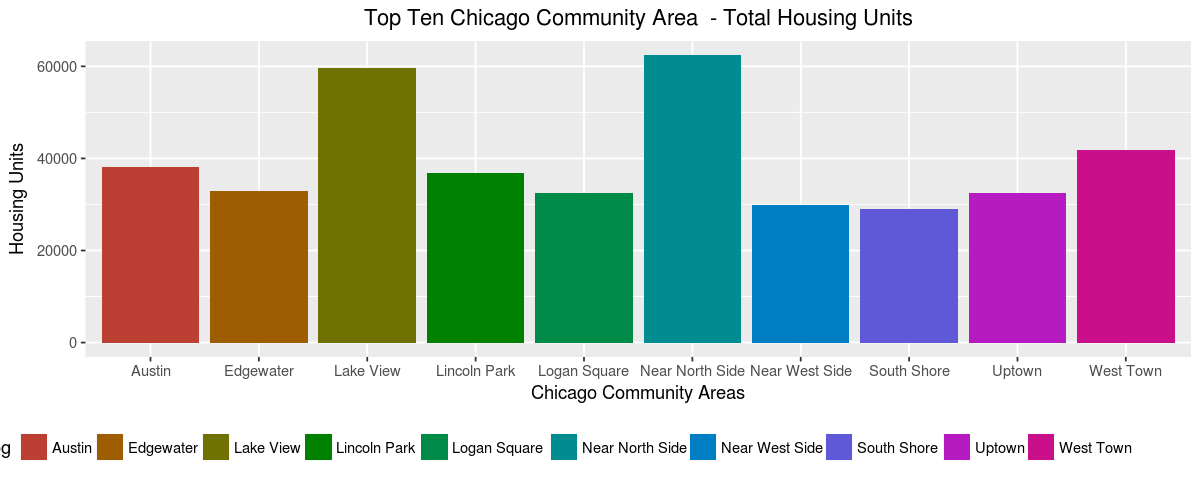

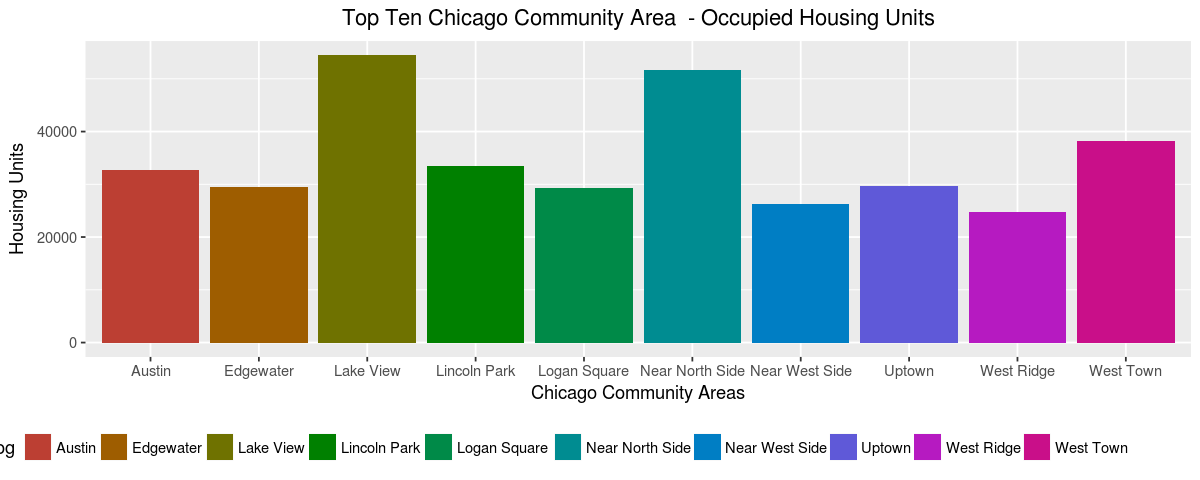

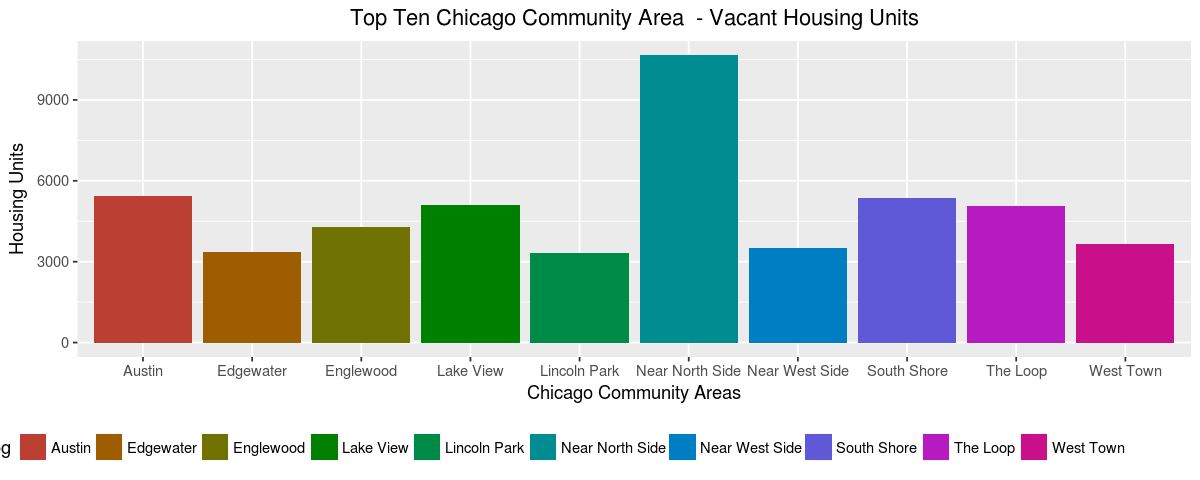

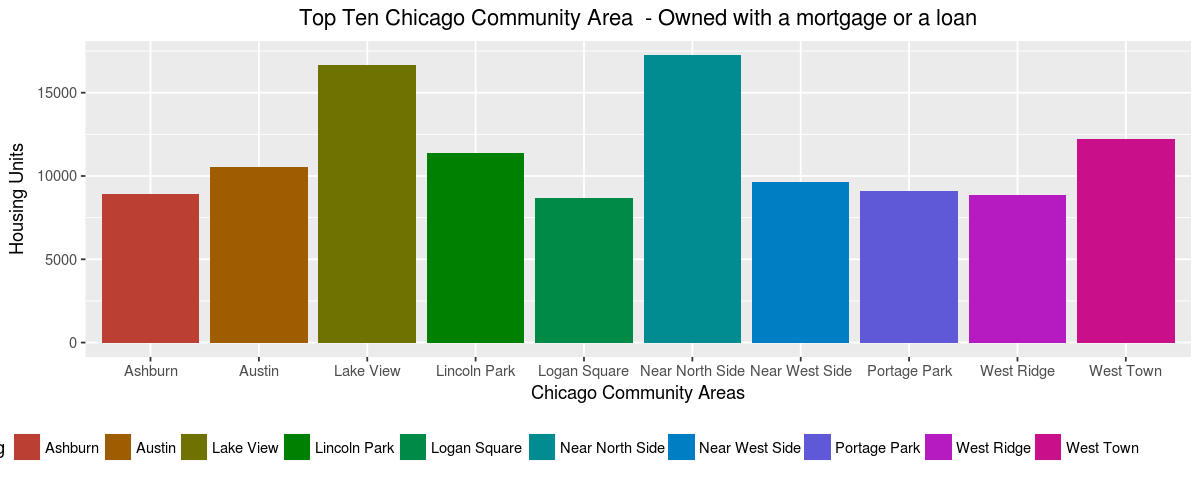

[[1]]

[[2]]
[[2]]$`Not Hispanic or Latino, White alone`

[[2]]$`Not Hispanic or Latino, Black or African American alone`

[[2]]$`Not Hispanic or Latino, American Indian and Alaska Native alone`

[[2]]$`Not Hispanic or Latino, Asian alone`

[[2]]$`Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone`

[[2]]$`Not Hispanic or Latino, Some Other Race alone`

[[2]]$`Not Hispanic or Latino, Two or More Races`

[[2]]$`Hispanic or Latino`


[[3]]
[[3]]$`Age: Under 5 years old`

[[3]]$`Age: 5 to 9 years`

[[3]]$`Age: 10 to 14 years`

[[3]]$`Age: 15 to 17 years`

[[3]]$`Age: 18 and 19 years`

[[3]]$`Age: 20 years`

[[3]]$`Age: 21 years`

[[3]]$`Age: 22 to 24 years`

[[3]]$`Age: 25 to 29 years`

[[3]]$`Age: 30 to 34 years`

[[3]]$`Age: 35 to 39 years`

[[3]]$`Age: 40 to 44 years`

[[3]]$`Age: 45 to 49 years`

[[3]]$`Age: 50 to 54 years`

[[3]]$`Age: 55 to 59 years`

[[3]]$`Age: 60 and 61 years`

[[3]]$`Age: 62 to 64 years`

[[3]]$`Age: 65 and 66 years`

[[3]]$`Age: 67 to 69 y

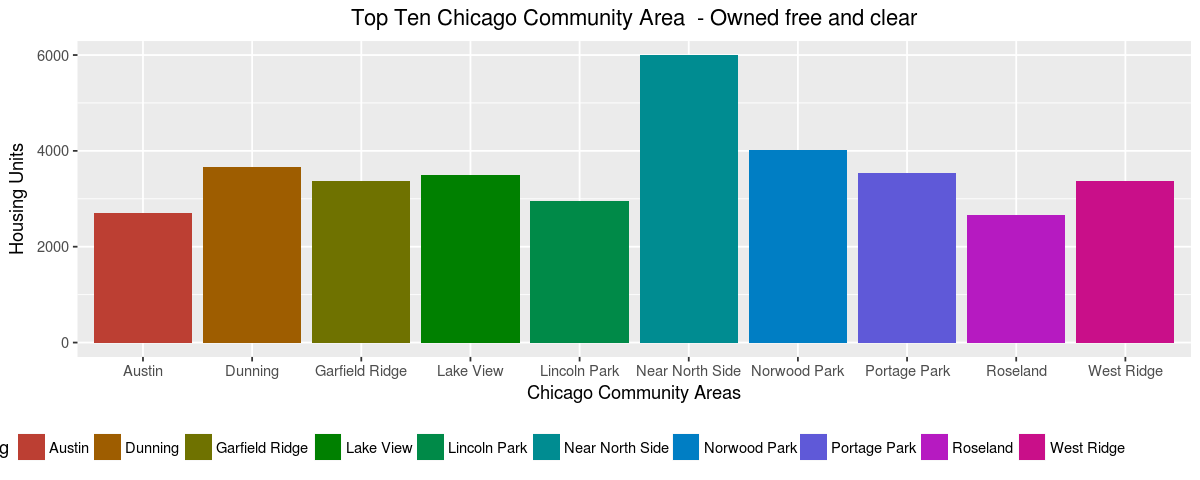

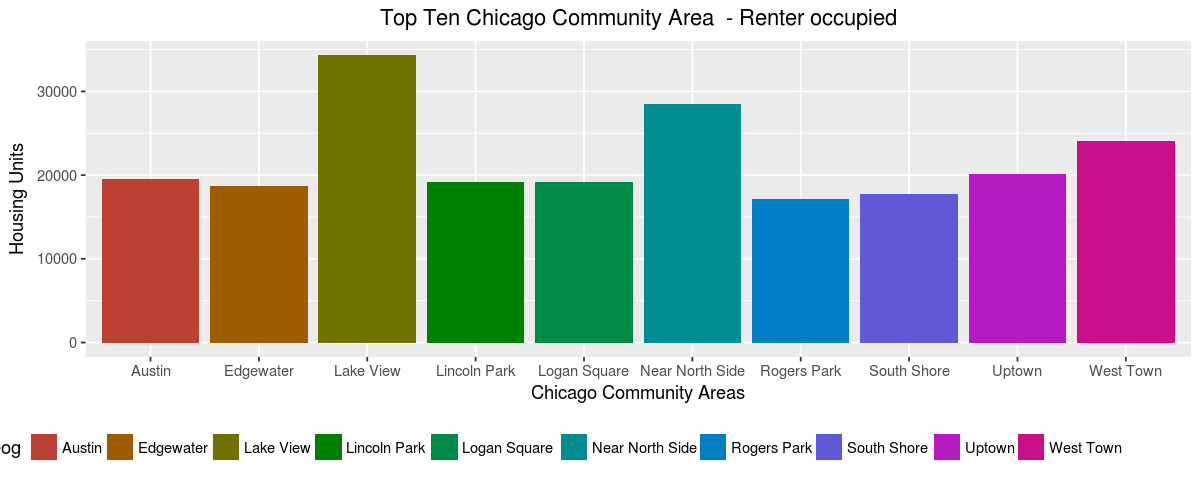

In [42]:
options(repr.plot.width=10, repr.plot.height=4)
graphing_fct()

## Microbenchmark

In [44]:
print(microbenchmark(extract_fct, reshape_fct, summarize_fct, graphing_fct))

Unit: nanoseconds
          expr min lq  mean median uq  max neval cld
   extract_fct  31 33 39.71     34 36  553   100   a
   reshape_fct  31 33 50.23     33 34 1723   100   a
 summarize_fct  31 33 41.89     33 34  888   100   a
  graphing_fct  31 33 39.01     34 37  475   100   a
